# Reporte Volumétrico - Polymarket Data Lake

**Alumno:** Pol Ballarín  
**Asignatura:** Sistemes Big Data - RA2  
**Fuente de datos:** Polymarket Gamma API  
**Formato de almacenamiento:** Delta Lake  
**Estructura:** `raw/` → tags, events, markets, series

### Contenido del reporte
1. Cantidad de registros por entidad
2. Distribución de mercados (activos vs. cerrados)
3. Análisis de relaciones (mercados por evento, eventos por serie, tags por entidad)

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from deltalake import DeltaTable
import os

RAW_DIR = "raw"
ENDPOINTS = ["tags", "events", "markets", "series"]

# Cargar todos los Delta Tables
dfs = {}
for ep in ENDPOINTS:
    path = os.path.join(RAW_DIR, ep)
    if os.path.exists(path):
        dfs[ep] = DeltaTable(path).to_pandas()
        print("Cargado correctamente")
    else:
        print(f"{ep}: NO ENCONTRADO")

Cargado correctamente
Cargado correctamente
Cargado correctamente
Cargado correctamente


---
## 1. Cantidad de Registros por Entidad

In [2]:
summary = pd.DataFrame([
    {"Endpoint": ep, "Registros": f"{len(df):,}", "Columnas": len(df.columns)}
    for ep, df in dfs.items()
])
summary

,Endpoint,Registros,Columnas
0,tags,"5,025",12
1,events,"195,222",97
2,markets,"436,728",138
3,series,"1,073",33


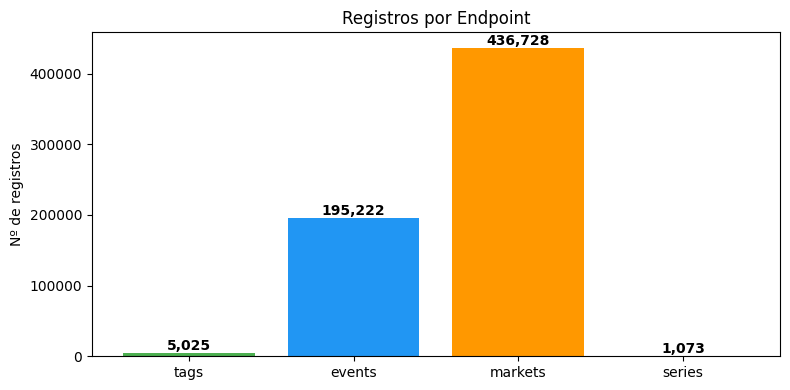

In [3]:
fig, ax = plt.subplots(figsize=(8, 4))
counts = [len(df) for df in dfs.values()]
bars = ax.bar(dfs.keys(), counts, color=["#4CAF50", "#2196F3", "#FF9800", "#9C27B0"])
ax.set_title("Registros por Endpoint")
ax.set_ylabel("Nº de registros")
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{count:,}",
            ha="center", va="bottom", fontsize=10, fontweight="bold")
plt.tight_layout()
plt.show()

### 1.1 Detalle por Endpoint

In [4]:
df_tags = dfs["tags"]
print(f"TAGS: {len(df_tags):,} registros | {len(df_tags.columns)} columnas")
print(f"Columnas: {list(df_tags.columns)}")
df_tags.head(5)

TAGS: 5,025 registros | 12 columnas
Columnas: ['id', 'label', 'slug', 'publishedAt', 'createdAt', 'updatedAt', 'requiresTranslation', 'forceShow', 'isCarousel', 'updatedBy', 'forceHide', 'createdBy']


,id,label,slug,publishedAt,createdAt,updatedAt,requiresTranslation,forceShow,isCarousel,updatedBy,forceHide,createdBy
0,671,jto,jto,2023-12-07 19:16:45.979+00,2023-12-07T19:16:45.993Z,2026-02-06T20:01:39.282804Z,False,None,None,None,None,None
1,101592,Tom Aspinal,tom-aspinal,None,2024-12-31T19:48:27.938591Z,2026-02-06T20:01:39.296759Z,False,None,None,None,None,None
2,101115,Preston,preston,None,2024-10-28T20:41:17.828152Z,2026-02-06T20:01:39.322562Z,False,None,None,None,None,None
3,746,detroit pistons,detroit-pistons,2023-12-18 18:24:38.687+00,2023-12-18T18:24:38.708Z,2026-02-06T20:01:39.323344Z,False,None,None,None,None,None
4,1493,spider-man,spider-man,2024-02-27 19:31:50.152+00,2024-02-27T19:31:50.171Z,2026-02-06T20:01:39.389634Z,False,None,None,None,None,None


In [5]:
df_series = dfs["series"]
print(f"SERIES: {len(df_series):,} registros | {len(df_series.columns)} columnas")
df_series.head(5)

SERIES: 1,073 registros | 33 columnas


,id,ticker,slug,title,seriesType,recurrence,image,icon,active,closed,...,layout,publishedAt,createdBy,updatedBy,commentsEnabled,competitive,startDate,pythTokenID,cgAssetName,description
0,11149,trump-and-netanyahu-shake-hands,trump-and-netanyahu-shake-hands,Trump and Netanyahu shake hands,single,monthly,,,True,False,...,None,None,None,None,None,None,None,None,None,None
1,10117,eth-up-or-down-hourly,eth-up-or-down-hourly,ETH Up or Down Hourly,single,hourly,https://polymarket-upload.s3.us-east-2.amazona...,https://polymarket-upload.s3.us-east-2.amazona...,True,False,...,None,None,None,None,None,None,None,None,None,None
2,10816,elon-tweets-48h,elon-tweets-48h,Elon Tweets 48H,single,daily,,,True,False,...,None,None,None,None,None,None,None,None,None,None
3,10752,cricket-australia,cricket-australia,Cricket Australia,single,daily,,,True,False,...,None,None,None,None,None,None,None,None,None,None
4,10127,us-strikes-iran,us-strikes-iran,US strikes iran,single,monthly,,,True,False,...,None,None,None,None,None,None,None,None,None,None


In [6]:
df_events = dfs["events"]
print(f"EVENTS: {len(df_events):,} registros | {len(df_events.columns)} columnas")
df_events.head(5)

EVENTS: 195,222 registros | 97 columnas


,id,ticker,slug,title,description,resolutionSource,startDate,creationDate,endDate,image,...,turnProviderId,eventMetadata_externalPartners,sport_id,sport_sport,sport_image,sport_resolution,sport_ordering,sport_tags,sport_series,sport_createdAt
0,2890,nba-will-the-mavericks-beat-the-grizzlies-by-m...,nba-will-the-mavericks-beat-the-grizzlies-by-m...,NBA: Will the Mavericks beat the Grizzlies by ...,"In the upcoming NBA game, scheduled for Decemb...",https://www.nba.com/games,2021-12-04T00:00:00Z,2021-12-04T00:00:00Z,2021-12-04T00:00:00Z,https://polymarket-upload.s3.us-east-2.amazona...,...,None,None,None,None,None,None,None,None,None,None
1,2891,nfl-will-the-falcons-beat-the-panthers-by-more...,nfl-will-the-falcons-beat-the-panthers-by-more...,NFL: Will the Falcons beat the Panthers by mor...,In the upcoming NFL game:\n\nIf the Atlanta Fa...,https://www.nfl.com/scores/,2021-10-31T00:00:00Z,2021-10-31T00:00:00Z,2021-10-31T00:00:00Z,https://polymarket-upload.s3.us-east-2.amazona...,...,None,None,None,None,None,None,None,None,None,None
2,2892,in-game-trading-will-the-49ers-beat-the-packer...,in-game-trading-will-the-49ers-beat-the-packer...,(In-Game Trading) Will the 49ers beat the Pack...,This is a market on whether the San Francisco ...,https://www.nfl.com/scores/,2021-09-26T00:00:00Z,2021-09-26T00:00:00Z,2021-09-26T00:00:00Z,https://polymarket-upload.s3.us-east-2.amazona...,...,None,None,None,None,None,None,None,None,None,None
3,2893,2022-norway-chess-will-magnus-carlsen-lose-any...,2022-norway-chess-will-magnus-carlsen-lose-any...,2022 Norway Chess: Will Magnus Carlsen lose an...,The Norway Chess is a prestigious annual close...,https://norwaychess.no/,2022-05-31T00:00:00Z,2022-05-31T00:00:00Z,2022-06-11T00:00:00Z,https://polymarket-upload.s3.us-east-2.amazona...,...,None,None,None,None,None,None,None,None,None,None
4,2894,nba-will-the-heat-beat-the-wizards-by-more-tha...,nba-will-the-heat-beat-the-wizards-by-more-tha...,NBA: Will the Heat beat the Wizards by more th...,"In the upcoming NBA game, scheduled for Novemb...",http://nba.com/games,2021-11-18T00:00:00Z,2021-11-18T00:00:00Z,2021-11-18T00:00:00Z,https://polymarket-upload.s3.us-east-2.amazona...,...,None,None,None,None,None,None,None,None,None,None


In [7]:
df_markets = dfs["markets"]
print(f"MARKETS: {len(df_markets):,} registros | {len(df_markets.columns)} columnas")
df_markets.head(5)

MARKETS: 436,728 registros | 138 columnas


,id,question,conditionId,slug,twitterCardImage,endDate,category,liquidity,image,icon,...,showGmpSeries,showGmpOutcome,acceptingOrdersTimestamp,deployingTimestamp,gameId,sportsMarketType,line,eventStartTime,groupItemRange,makerRebatesFeeShareBps
0,12,Will Joe Biden get Coronavirus before the elec...,0xe3b423dfad8c22ff75c9899c4e8176f628cf4ad4caa0...,will-joe-biden-get-coronavirus-before-the-elec...,https://polymarket-static.s3.us-east-2.amazona...,2020-11-04T00:00:00Z,US-current-affairs,0,https://polymarket-upload.s3.us-east-2.amazona...,https://polymarket-upload.s3.us-east-2.amazona...,...,None,None,None,None,None,None,None,None,None,None
1,17,Will Airbnb begin publicly trading before Jan ...,0x44f10d1cd5aaed4b7ae0b5edb76790f54f45dc0bcaa8...,will-airbnb-begin-publicly-trading-before-jan-...,https://polymarket-static.s3.us-east-2.amazona...,2021-01-02T00:00:00Z,Tech,0,https://polymarket-upload.s3.us-east-2.amazona...,https://polymarket-upload.s3.us-east-2.amazona...,...,None,None,None,None,None,None,None,None,None,None
2,18,Will a new Supreme Court Justice be confirmed ...,0x3e0524de013d9dc359f5eb370773f25de2f03d320029...,will-a-new-supreme-court-justice-be-confirmed-...,https://polymarket-static.s3.us-east-2.amazona...,2020-11-04T00:00:00Z,US-current-affairs,0,https://polymarket-upload.s3.us-east-2.amazona...,https://polymarket-upload.s3.us-east-2.amazona...,...,None,None,None,None,None,None,None,None,None,None
3,19,Will Kim Kardashian and Kanye West divorce bef...,0x9b946f54f3428aafc308c33aa04a943fe13a011bdac9...,will-kim-kardashian-and-kanye-west-divorce-bef...,https://polymarket-static.s3.us-east-2.amazona...,2021-01-02T00:00:00Z,Pop-Culture,0.179651,https://polymarket-upload.s3.us-east-2.amazona...,https://polymarket-upload.s3.us-east-2.amazona...,...,None,None,None,None,None,None,None,None,None,None
4,20,Will Coinbase begin publicly trading before Ja...,0x5d1a1ab716fd06943441fe27cde0089651ce769bec55...,will-coinbase-begin-publicly-trading-before-ja...,https://polymarket-static.s3.us-east-2.amazona...,2021-01-02T00:00:00Z,Crypto,0.367501,https://polymarket-upload.s3.us-east-2.amazona...,https://polymarket-upload.s3.us-east-2.amazona...,...,None,None,None,None,None,None,None,None,None,None


---
## 2. Distribución de Mercados y Eventos (Activos vs. Cerrados)

In [8]:
mk_active = df_markets["active"].apply(lambda x: str(x).lower() == "true").sum()
mk_inactive = len(df_markets) - mk_active
mk_closed = df_markets["closed"].apply(lambda x: str(x).lower() == "true").sum()
mk_open = len(df_markets) - mk_closed

print(f"Total mercados:  {len(df_markets):,}")
print(f"Activos:         {mk_active:,} ({mk_active/len(df_markets)*100:.1f}%)")
print(f"Inactivos:       {mk_inactive:,} ({mk_inactive/len(df_markets)*100:.1f}%)")
print(f"Cerrados:        {mk_closed:,} ({mk_closed/len(df_markets)*100:.1f}%)")
print(f"Abiertos:        {mk_open:,} ({mk_open/len(df_markets)*100:.1f}%)")

Total mercados:  436,728
Activos:         436,728 (100.0%)
Inactivos:       0 (0.0%)
Cerrados:        409,473 (93.8%)
Abiertos:        27,255 (6.2%)


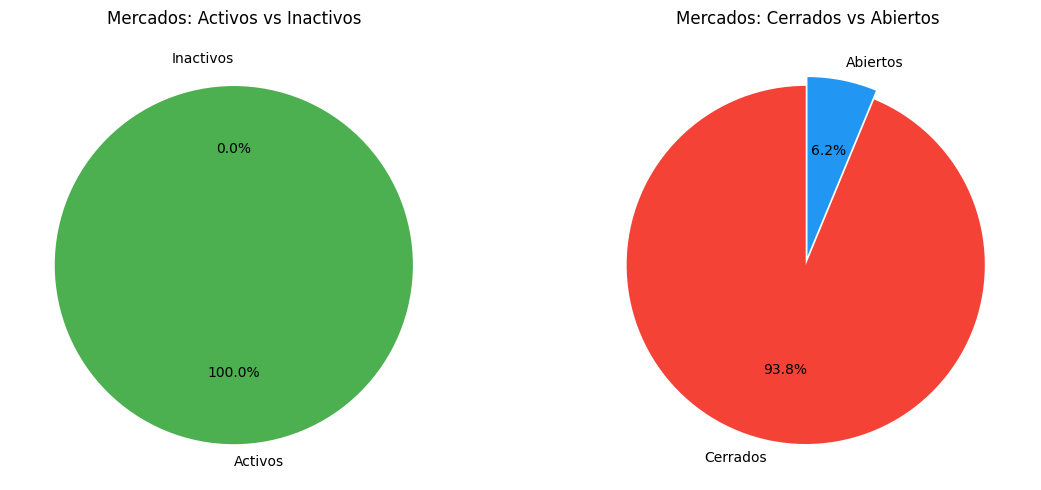

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].pie([mk_active, mk_inactive], labels=["Activos", "Inactivos"],
            autopct="%1.1f%%", colors=["#4CAF50", "#ccc"],
            explode=(0.05, 0), startangle=90)
axes[0].set_title("Mercados: Activos vs Inactivos")

axes[1].pie([mk_closed, mk_open], labels=["Cerrados", "Abiertos"],
            autopct="%1.1f%%", colors=["#F44336", "#2196F3"],
            explode=(0.05, 0), startangle=90)
axes[1].set_title("Mercados: Cerrados vs Abiertos")

plt.tight_layout()
plt.show()

Total eventos:   195,222
Activos:         195,222 (100.0%)
Inactivos:       0 (0.0%)
Cerrados:        188,890 (96.8%)
Abiertos:        6,332 (3.2%)


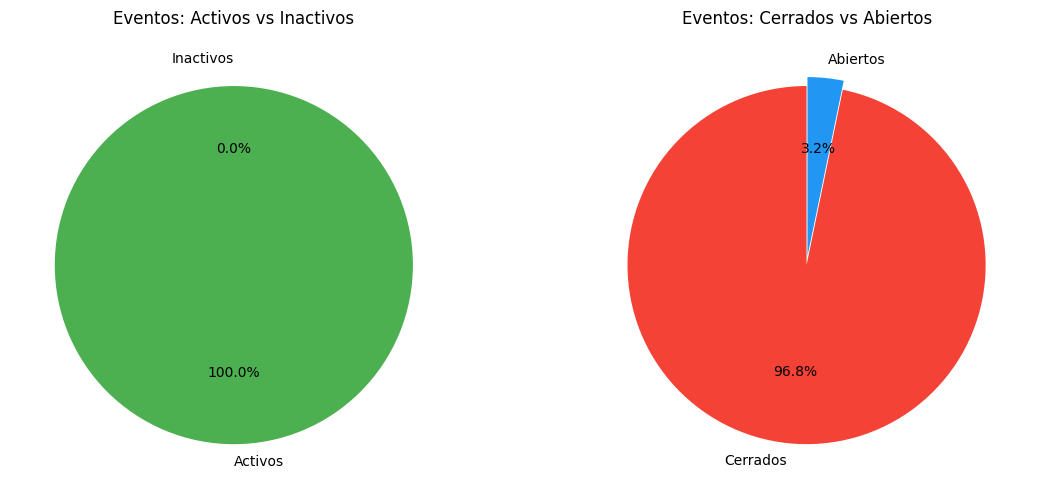

In [10]:
ev_active = df_events["active"].apply(lambda x: str(x).lower() == "true").sum()
ev_inactive = len(df_events) - ev_active
ev_closed = df_events["closed"].apply(lambda x: str(x).lower() == "true").sum()
ev_open = len(df_events) - ev_closed

print(f"Total eventos:   {len(df_events):,}")
print(f"Activos:         {ev_active:,} ({ev_active/len(df_events)*100:.1f}%)")
print(f"Inactivos:       {ev_inactive:,} ({ev_inactive/len(df_events)*100:.1f}%)")
print(f"Cerrados:        {ev_closed:,} ({ev_closed/len(df_events)*100:.1f}%)")
print(f"Abiertos:        {ev_open:,} ({ev_open/len(df_events)*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pie([ev_active, ev_inactive], labels=["Activos", "Inactivos"],
            autopct="%1.1f%%", colors=["#4CAF50", "#ccc"],
            explode=(0.05, 0), startangle=90)
axes[0].set_title("Eventos: Activos vs Inactivos")
axes[1].pie([ev_closed, ev_open], labels=["Cerrados", "Abiertos"],
            autopct="%1.1f%%", colors=["#F44336", "#2196F3"],
            explode=(0.05, 0), startangle=90)
axes[1].set_title("Eventos: Cerrados vs Abiertos")
plt.tight_layout()
plt.show()

In [11]:
# Estadísticas de volumen de mercados
df_markets["vol"] = pd.to_numeric(df_markets["volumeNum"], errors="coerce")

print("Estadísticas de Volumen (Markets):")
print(f"  Volumen total:   ${df_markets['vol'].sum():,.2f}")
print(f"  Volumen medio:   ${df_markets['vol'].mean():,.2f}")
print(f"  Volumen mediana: ${df_markets['vol'].median():,.2f}")
print(f"  Volumen máximo:  ${df_markets['vol'].max():,.2f}")

Estadísticas de Volumen (Markets):
  Volumen total:   $51,921,842,677.75
  Volumen medio:   $128,187.84
  Volumen mediana: $3,625.61
  Volumen máximo:  $1,531,479,284.50


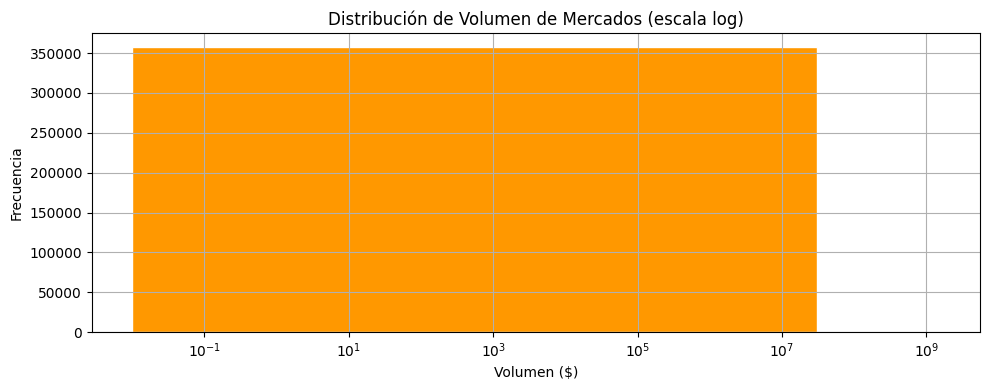

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
df_markets[df_markets["vol"] > 0]["vol"].hist(bins=50, ax=ax, color="#FF9800", edgecolor="white")
ax.set_xscale("log")
ax.set_title("Distribución de Volumen de Mercados (escala log)")
ax.set_xlabel("Volumen ($)")
ax.set_ylabel("Frecuencia")
plt.tight_layout()
plt.show()

In [13]:
top_markets = df_markets.nlargest(10, "vol")[["question", "vol"]].copy()
top_markets["vol"] = top_markets["vol"].apply(lambda x: f"${x:,.0f}")
top_markets.columns = ["Mercado", "Volumen"]
top_markets.reset_index(drop=True)

,Mercado,Volumen
0,Will Donald Trump win the 2024 US Presidential...,"$1,531,479,285"
1,Will Kamala Harris win the 2024 US Presidentia...,"$1,037,039,118"
2,Will Donald Trump be inaugurated?,"$400,409,527"
3,Will the Sacramento Kings win the 2025 NBA Fin...,"$378,011,507"
4,Will Nicolae Ciucă win the 2024 Romanian Presi...,"$326,507,671"
5,Will Zelenskyy wear a suit before July?,"$242,231,180"
6,Will any other Republican Politician win the 2...,"$241,655,100"
7,Fed decreases interest rates by 50+ bps after ...,"$235,065,167"
8,Fed increases interest rates by 25+ bps after ...,"$216,455,743"
9,Kamala Harris wins the popular vote?,"$163,779,787"


---
## 3. Análisis de Relaciones

Jerarquía de Polymarket: **Tags → Series → Events → Markets**

Analizamos cuántos mercados dependen de cada evento, cuántos eventos dependen de cada serie, y la distribución de tags.

### 3.1 Mercados por Evento

In [14]:
def safe_json_parse(val):
    """Intenta parsear un string JSON, devuelve lista vacía si falla."""
    if pd.isna(val) or val in ('None', 'nan', '', '[]'):
        return []
    try:
        parsed = json.loads(val)
        return parsed if isinstance(parsed, list) else [parsed]
    except (json.JSONDecodeError, TypeError):
        return []

# Buscar columna con event_id en markets
event_id_col = None
for col in df_markets.columns:
    if col in ('groupItemTitle', 'events'):
        continue
    if 'event' in col.lower() and 'id' in col.lower():
        event_id_col = col
        break

if event_id_col and event_id_col in df_markets.columns:
    markets_per_event = df_markets.groupby(event_id_col).size().reset_index(name="num_markets")
    print(f"Columna usada: {event_id_col}")
else:
    event_ids = []
    for _, row in df_markets.iterrows():
        events_data = safe_json_parse(row.get('events', '[]'))
        if events_data:
            for ev in events_data:
                eid = ev.get('id', ev) if isinstance(ev, dict) else ev
                event_ids.append(eid)
        else:
            event_ids.append('sin_evento')
    markets_per_event = pd.Series(event_ids).value_counts().reset_index()
    markets_per_event.columns = ["event_id", "num_markets"]
    print("Columna usada: events (JSON parseado)")

print(f"\nEventos únicos referenciados por mercados: {len(markets_per_event):,}")
print(f"\nDistribución de mercados por evento:")
print(markets_per_event["num_markets"].describe())

Columna usada: events (JSON parseado)

Eventos únicos referenciados por mercados: 195,288

Distribución de mercados por evento:
count    195288.000000
mean          2.236328
std           4.616831
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         147.000000
Name: num_markets, dtype: float64


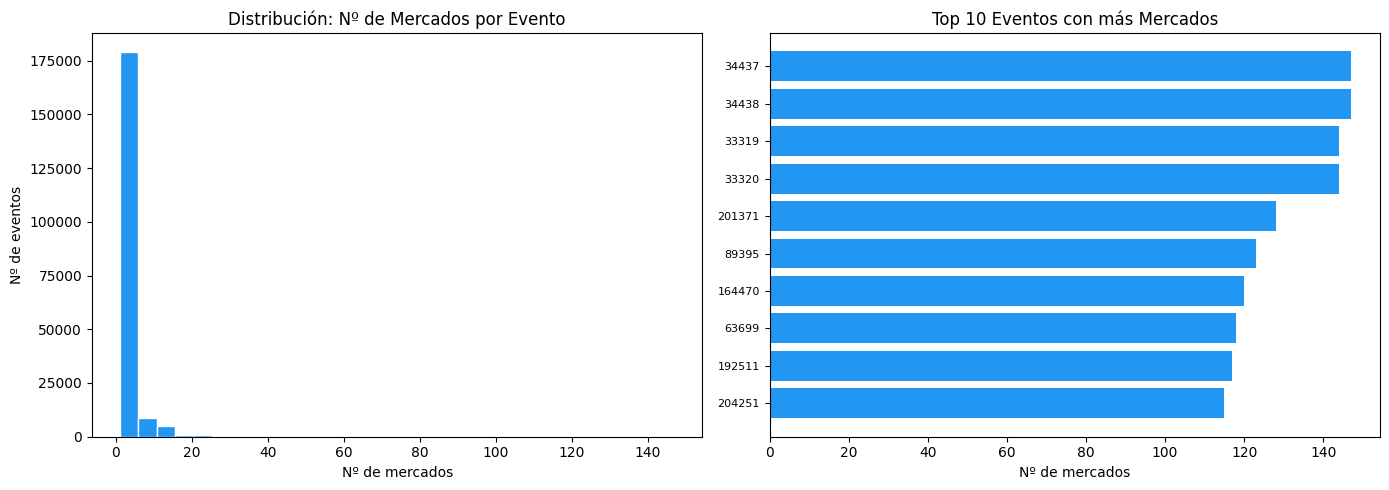

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(markets_per_event["num_markets"], bins=30, color="#2196F3", edgecolor="white")
axes[0].set_title("Distribución: Nº de Mercados por Evento")
axes[0].set_xlabel("Nº de mercados")
axes[0].set_ylabel("Nº de eventos")

top10 = markets_per_event.nlargest(10, "num_markets")
axes[1].barh(range(len(top10)), top10["num_markets"].values, color="#2196F3")
axes[1].set_yticks(range(len(top10)))
labels = top10.iloc[:, 0].astype(str).str[:30].values
axes[1].set_yticklabels(labels, fontsize=8)
axes[1].set_title("Top 10 Eventos con más Mercados")
axes[1].set_xlabel("Nº de mercados")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### 3.2 Eventos por Serie

In [16]:
series_event_counts = []
for _, row in df_series.iterrows():
    series_title = row.get('title', 'N/A')
    series_id = row.get('id', 'N/A')
    events_data = []
    for col in df_series.columns:
        if 'events' in col.lower():
            parsed = safe_json_parse(row.get(col, '[]'))
            if parsed:
                events_data = parsed
                break
    n_events = len(events_data) if events_data else 0
    series_event_counts.append({"series_id": series_id, "title": series_title, "num_events": n_events})

df_series_events = pd.DataFrame(series_event_counts)
print(f"Total series: {len(df_series_events):,}")
print(f"Series con eventos: {(df_series_events['num_events'] > 0).sum():,}")
print(f"Series sin eventos: {(df_series_events['num_events'] == 0).sum():,}")
print(f"\nDistribución de eventos por serie:")
print(df_series_events["num_events"].describe())

Total series: 1,073
Series con eventos: 945
Series sin eventos: 128

Distribución de eventos por serie:
count     1073.000000
mean       149.739049
std       1080.936070
min          0.000000
25%          2.000000
50%          3.000000
75%         12.000000
max      14635.000000
Name: num_events, dtype: float64


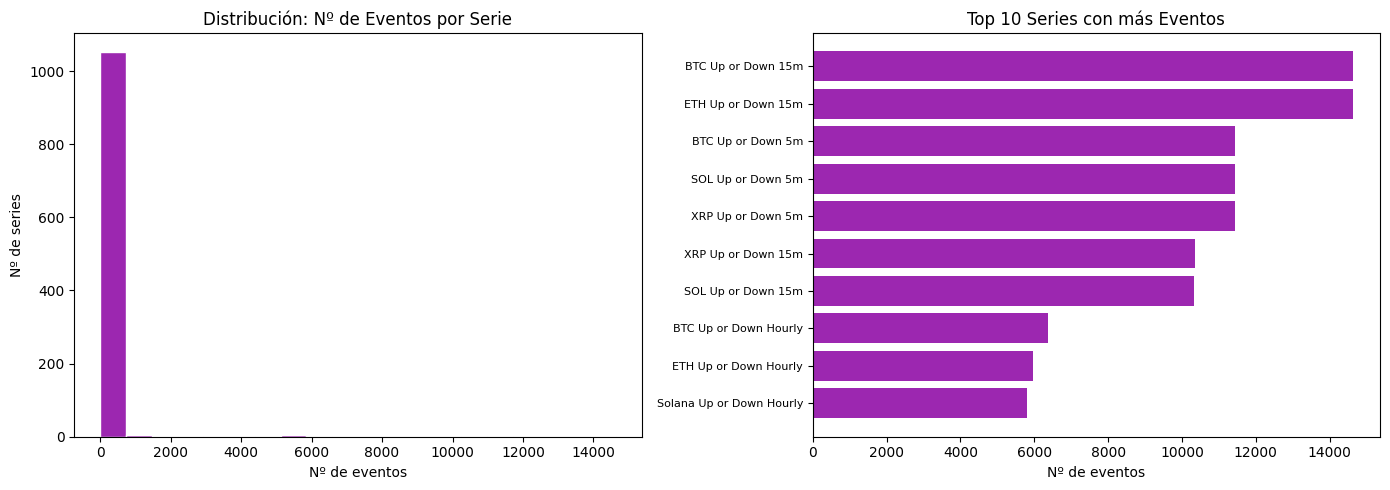

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_series_events["num_events"], bins=20, color="#9C27B0", edgecolor="white")
axes[0].set_title("Distribución: Nº de Eventos por Serie")
axes[0].set_xlabel("Nº de eventos")
axes[0].set_ylabel("Nº de series")

top10_series = df_series_events.nlargest(10, "num_events")
axes[1].barh(range(len(top10_series)), top10_series["num_events"].values, color="#9C27B0")
axes[1].set_yticks(range(len(top10_series)))
axes[1].set_yticklabels(top10_series["title"].str[:35].values, fontsize=8)
axes[1].set_title("Top 10 Series con más Eventos")
axes[1].set_xlabel("Nº de eventos")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### 3.3 Tags por Entidad

In [18]:
tag_counts = {}
for _, row in df_events.iterrows():
    for col in df_events.columns:
        if 'tags' in col.lower():
            tags = safe_json_parse(row.get(col, '[]'))
            for tag in tags:
                label = tag.get('label', tag) if isinstance(tag, dict) else str(tag)
                tag_counts[label] = tag_counts.get(label, 0) + 1
            break

df_tag_usage = pd.DataFrame([
    {"Tag": k, "Nº eventos": v} for k, v in tag_counts.items()
]).sort_values("Nº eventos", ascending=False).reset_index(drop=True)

print(f"Tags únicos usados en eventos: {len(df_tag_usage):,}")
print(f"\nTop 20 tags más usados:")
df_tag_usage.head(20)

Tags únicos usados en eventos: 4,802

Top 20 tags más usados:


,Tag,Nº eventos
0,Hide From New,130090
1,Crypto,127929
2,Recurring,127627
3,Crypto Prices,126649
4,Up or Down,124547
5,15M,49819
6,5M,45773
7,Sports,45719
8,Games,45567
9,Bitcoin,34634


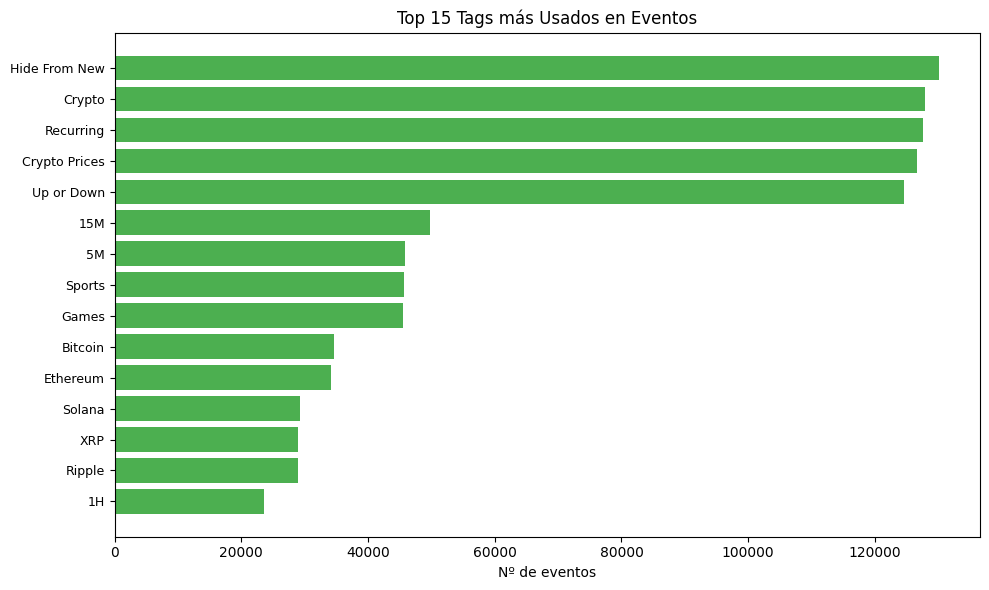

In [19]:
top_tags = df_tag_usage.head(15)
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(top_tags)), top_tags["Nº eventos"].values, color="#4CAF50")
ax.set_yticks(range(len(top_tags)))
ax.set_yticklabels(top_tags["Tag"].values, fontsize=9)
ax.set_title("Top 15 Tags más Usados en Eventos")
ax.set_xlabel("Nº de eventos")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### 3.4 Resumen de Relaciones

In [20]:
print("=" * 55)
print("RESUMEN DE RELACIONES")
print("=" * 55)
print(f"Mercados por evento (media):  {markets_per_event['num_markets'].mean():.1f}")
print(f"Mercados por evento (max):    {markets_per_event['num_markets'].max()}")
print(f"Eventos por serie (media):    {df_series_events['num_events'].mean():.1f}")
print(f"Eventos por serie (max):      {df_series_events['num_events'].max()}")
print(f"Tags únicos en uso:           {len(df_tag_usage):,}")
print(f"Tag más popular:              {df_tag_usage.iloc[0]['Tag']} ({df_tag_usage.iloc[0]['Nº eventos']:,} eventos)")
print("=" * 55)

RESUMEN DE RELACIONES
Mercados por evento (media):  2.2
Mercados por evento (max):    147
Eventos por serie (media):    149.7
Eventos por serie (max):      14635
Tags únicos en uso:           4,802
Tag más popular:              Hide From New (130,090 eventos)


---
## 4. Peso en Disco (Delta Lake)

In [21]:
def get_dir_size(path):
    total = 0
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            total += os.path.getsize(os.path.join(dirpath, f))
    return total

sizes = []
for ep in ENDPOINTS:
    path = os.path.join(RAW_DIR, ep)
    if os.path.exists(path):
        size = get_dir_size(path)
        sizes.append({"Endpoint": ep, "Tamaño (MB)": f"{size / 1024**2:.2f}"})

df_sizes = pd.DataFrame(sizes)
total_mb = sum(get_dir_size(os.path.join(RAW_DIR, ep)) for ep in ENDPOINTS if os.path.exists(os.path.join(RAW_DIR, ep)))
print(f"Tamaño total en disco: {total_mb / 1024**2:.2f} MB")
df_sizes

Tamaño total en disco: 819.49 MB


,Endpoint,Tamaño (MB)
0,tags,0.32
1,events,389.98
2,markets,348.35
3,series,80.83


---
## 5. Resumen Final

In [22]:
print("=" * 55)
print("RESUMEN FINAL - POLYMARKET DATA LAKE")
print("=" * 55)
total_registros = sum(len(df) for df in dfs.values())
print(f"Total registros extraídos: {total_registros:,}")
print(f"Total endpoints:           {len(dfs)}")
print(f"Formato:                   Delta Lake")
print(f"Destino S3:                s3://lasalle-bigdata-2025-2026/pol_ballarin/raw/")
print("=" * 55)
for ep, df in dfs.items():
    print(f"  {ep:10s} → {len(df):>10,} registros | {len(df.columns):>3} columnas")
print("=" * 55)

RESUMEN FINAL - POLYMARKET DATA LAKE
Total registros extraídos: 638,048
Total endpoints:           4
Formato:                   Delta Lake
Destino S3:                s3://lasalle-bigdata-2025-2026/pol_ballarin/raw/
  tags       →      5,025 registros |  12 columnas
  events     →    195,222 registros |  97 columnas
  markets    →    436,728 registros | 139 columnas
  series     →      1,073 registros |  33 columnas
